In [1]:
#importing relevant packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#dictionary with parish names as keys and device ids as values
parish_sensor_dict = {'NTINDA':930434, 'BUGOLOBI':718028, 'NANTABULIRWA':912224, 'KIREKA':930426, 'LUWAFU':930427, 
                     'BANDA':912223, 'MBUYA II':912222, 'NAKASERO II':912220, 'KIWATULE':870145, 'KYALIWAJJALA':870143,
                     'BUTABIKA':870144, 'NANSANA WEST':870147, 'NANSANA EAST':870142, 'BUSEGA':870139, 'KYANJA':832255,
                     'BUSABALA':832252, 'BUNAMWAYA':832253, 'KYEBANDO':832254, 'LUKULI':832251, 'BUKOTO I':782720,
                     'KANSANGA':782719, 'KASUBI':782718, 'NAGURU II':755614, 'MAKINDYE I':755612,
                     'MAKERERE UNIVERSITY':870146, 'LUBAGA':737276, 'BWEYOGERERE':737273, 'CIVIC CENTRE':689761}

In [3]:
def preprocessing(parish):
    '''
    Collects and preprocesses data
    '''
    channel_id = parish_sensor_dict[parish]
    
    #credentials to access GCP
    credentials = service_account.Credentials.from_service_account_file('C:/Users/User/AirQo-d982995f6dd8.json')
    project_id = 'airqo-250220'

    #creating a bigquery cliennt
    bqclient = bigquery.Client(credentials= credentials, project=project_id)
    
    query_string = "SELECT created_at, pm2_5 FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE channel_id = %d" %channel_id    
    bqdata = bqclient.query(query_string).result()
    data= bqdata.to_dataframe()
    
    data = data.sort_values(by = 'created_at', ascending=True)
    
    #filepath = r'D:/AirQo/sensor location model/feeds/'+str(channel_id)+'.csv'
    #cols = ['created_at', 'field1']
    #data = pd.read_csv(filepath,  parse_dates = ['created_at'], usecols=cols)
    
    data.set_index('created_at', inplace=True)
    hourly_data = data.resample('H').mean().round(2)  
    final_data=hourly_data.dropna()
    
    name = parish+'_pm2_5'
    final_data.rename(columns = {'pm2_5': name}, inplace = True)
    print (parish, ':done')
    
    return final_data

In [4]:
def merge_dfs(df_list):
    '''
    Merges several dataframes into one based on the index
    '''
    from functools import reduce
    final_df = reduce(lambda left,right: pd.merge(left,right,on='created_at'), df_list)
    return final_df

In [5]:
def find_correlation(data, column1, column2):
    '''
    Finds the correlation between 2 different columns in a dataframe
    '''
    correlation = data[column1].corr(data[column2])
    return correlation

In [6]:
def correlation_matrix_1(df):
    return df.corr()

In [7]:
def correlation_matrix_2(df):
    import seaborn as sns
    
    plt.figure(figsize=(5,5))
    sns.heatmap(correlation_matrix_1(df), annot=True, cmap=plt.cm.Reds)
    plt.show()

In [8]:
def correlation_matrix_3(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(correlation_matrix_1(df), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Correlation Matrix')
    fig.colorbar(cax, ticks=[.75,.8,.85,.90,.95,1])
    plt.show()

In [9]:
def correlation_matrix_4(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    f = plt.figure(figsize=(5,5))
    plt.matshow(correlation_matrix_1(df), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)

In [10]:
def standard_scaling(X):
    X_scaled = StandardScaler().fit_transform(X)
    #X_Scaled = pd.DataFrame(data=X_scaled[1:,1:],    # values
                 #index=X_scaled[1:,0],    # 1st column as index
                 #columns=X_scaled[0,1:])  # 1st row as the column names
    #X_scaled = pd.DataFrame(X_scaled)
    #X_scaled['coord_x'] = np.cos(X_scaled['lat']) * np.cos(X_scaled['long'])
    #X_scaled['coord_y'] = np.cos(X_scaled['lat']) * np.sin(X_scaled['long'])
    #X_scaled['coord_z'] = np.sin(X_scaled['lat'])
    #X_scaled =X_scaled.drop(['lat', 'long'], axis = 1)
    return X_scaled

In [11]:
def kmeans_clustering(X, data, sensor_number):
    X_scaled = standard_scaling(X)
    kmeans = KMeans(n_clusters = sensor_number).fit(X_scaled) 
    y_kmeans = kmeans.fit_predict(X_scaled)

    data['cluster'] = y_kmeans
  
    kmeans_samples = data.sample(frac=1).reset_index(drop=True)
    kmeans_samples= kmeans_samples.drop_duplicates('cluster', keep = 'last')
    
    kmeans_df_list = []
    for parish in kmeans_samples.parish:
        data = preprocessing(parish)
        kmeans_df_list.append(data)
        
    merged_df = merge_dfs(kmeans_df_list)
    #print (correlation_matrix_1(merged_df))
    correlation_matrix_2(merged_df)
    #correlation_matrix_3(merged_df)
    #correlation_matrix_4(merged_df)

In [12]:
#Loading geo_census data
file = 'gp_data.csv'
data = pd.read_csv(file)
data.head()

,district,subcounty,parish,population,households,fem_hhs,long,lat,km2,area,...,T123_per_person,not_T123_per_person,geometry,centroid,coord_x,coord_y,coord_z,cluster,average pm2_5,category
0,MUKONO,GOMA DIVISION,NANTABULIRWA,22241,4993,24.1,32.700915,0.333435,36.709773,36.376969,...,0.57,0.50,"POLYGON((32.7267447270215 0.326316235088979, 3...",POINT(32.7009147194484 0.333434596471355),0.266405,0.906592,0.327290,13,33.419091,Moderate
1,KAMPALA,NAKAWA DIVISION,KIWATULE,16915,4497,32.2,32.626714,0.368906,2.907240,2.881629,...,0.24,0.19,"POLYGON((32.6233900600041 0.357431522624744, 3...",POINT(32.6267137789408 0.368905588996633),0.328582,0.872929,0.360595,5,62.826075,Unhealthy
2,KAMPALA,NAKAWA DIVISION,NTINDA,5257,1356,33.6,32.618145,0.346663,2.693763,2.670111,...,0.79,0.63,"POLYGON((32.6076705687482 0.352370728818616, 3...",POINT(32.6181453501911 0.346662584687354),0.338856,0.877348,0.339761,13,52.140047,Unhealthy for Sensitive Groups
3,KAMPALA,NAKAWA DIVISION,BUKOTO I,23045,6386,30.8,32.596444,0.352933,2.097909,2.079645,...,0.15,0.12,"POLYGON((32.606305670664 0.351686206757447, 32...",POINT(32.5964437591639 0.352933214544676),0.356997,0.867801,0.345652,7,61.987713,Unhealthy
4,KAMPALA,NAKAWA DIVISION,BUGOLOBI,5023,1279,23.6,32.622657,0.311176,3.912260,3.877850,...,0.61,0.41,"POLYGON((32.6366037654667 0.30743072901818, 32...",POINT(32.6226571504019 0.311175541587068),0.338976,0.889579,0.306178,13,44.273017,Unhealthy for Sensitive Groups


##### using most features


c:\users\user\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


KYALIWAJJALA :done
BUGOLOBI :done
LUBAGA :done
KIREKA :done
KASUBI :done
                    KYALIWAJJALA_pm2_5  BUGOLOBI_pm2_5  LUBAGA_pm2_5  \
KYALIWAJJALA_pm2_5            1.000000        0.747969      0.624116   
BUGOLOBI_pm2_5                0.747969        1.000000      0.647668   
LUBAGA_pm2_5                  0.624116        0.647668      1.000000   
KIREKA_pm2_5                  0.705708        0.752365      0.634181   
KASUBI_pm2_5                  0.715272        0.760092      0.707530   

                    KIREKA_pm2_5  KASUBI_pm2_5  
KYALIWAJJALA_pm2_5      0.705708      0.715272  
BUGOLOBI_pm2_5          0.752365      0.760092  
LUBAGA_pm2_5            0.634181      0.707530  
KIREKA_pm2_5            1.000000      0.715060  
KASUBI_pm2_5            0.715060      1.000000  


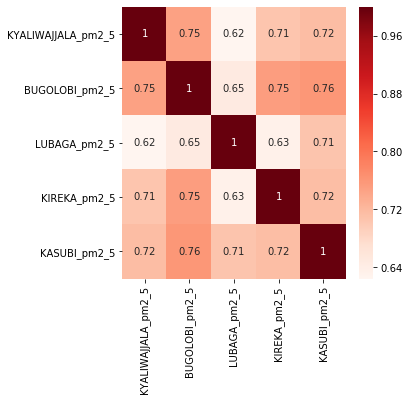

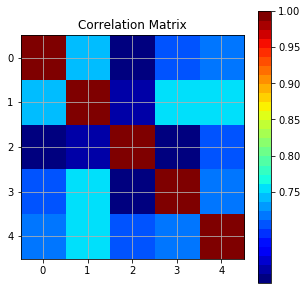

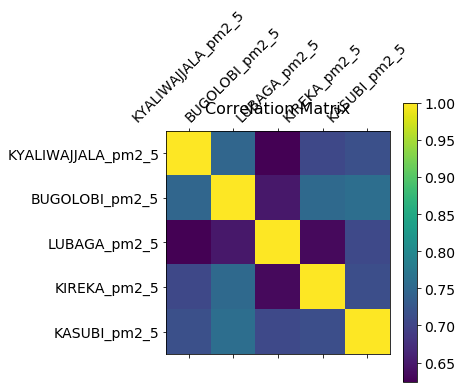

In [13]:
most = data[['light_par_tadooba_per_km', 'light_firewood_per_km', 'light_cow_dung_per_km', 'light_grass_per_km', 
          'cook_charc_per_km', 'cook_firewood_per_km', 'cook_dung_per_km', 'cook_grass_per_km', 'waste_burn_per_km',
          'kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 
          'hhs_density', 'T123_per_sqkm']]
kmeans_clustering(most, data, 5)

##### using 8 features

c:\users\user\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


KYALIWAJJALA :done
NANSANA EAST :done
LUBAGA :done
MAKINDYE I :done
CIVIC CENTRE :done
                    KYALIWAJJALA_pm2_5  NANSANA EAST_pm2_5  LUBAGA_pm2_5  \
KYALIWAJJALA_pm2_5            1.000000            0.500919      0.411104   
NANSANA EAST_pm2_5            0.500919            1.000000      0.555931   
LUBAGA_pm2_5                  0.411104            0.555931      1.000000   
MAKINDYE I_pm2_5              0.529474            0.699175      0.586922   
CIVIC CENTRE_pm2_5            0.522893            0.686288      0.595354   

                    MAKINDYE I_pm2_5  CIVIC CENTRE_pm2_5  
KYALIWAJJALA_pm2_5          0.529474            0.522893  
NANSANA EAST_pm2_5          0.699175            0.686288  
LUBAGA_pm2_5                0.586922            0.595354  
MAKINDYE I_pm2_5            1.000000            0.831704  
CIVIC CENTRE_pm2_5          0.831704            1.000000  


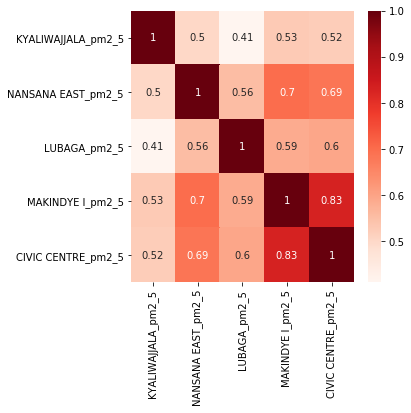

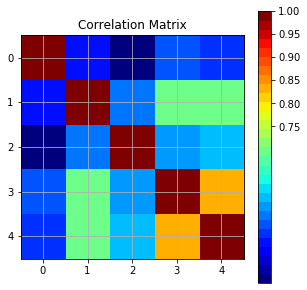

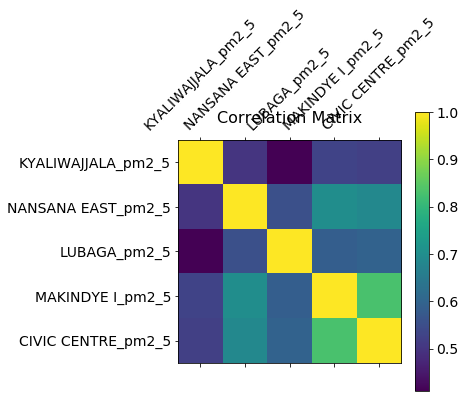

In [14]:
eight_features = data[['cook_charc_per_km', 'cook_firewood_per_km', 'waste_burn_per_km', 'kitch_outside_built_per_km',
                       'kitch_make_shift_per_km', 'kitch_open_space_per_km', 'pop_density', 'hhs_density']]

kmeans_clustering(eight_features, data, 5)

###### using 6 features

c:\users\user\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


KYEBANDO :done
NANSANA EAST :done
BUNAMWAYA :done
BUSEGA :done
MAKERERE UNIVERSITY :done
                           KYEBANDO_pm2_5  NANSANA EAST_pm2_5  \
KYEBANDO_pm2_5                   1.000000            0.637776   
NANSANA EAST_pm2_5               0.637776            1.000000   
BUNAMWAYA_pm2_5                  0.600134            0.757496   
BUSEGA_pm2_5                     0.596920            0.813585   
MAKERERE UNIVERSITY_pm2_5        0.588385            0.801210   

                           BUNAMWAYA_pm2_5  BUSEGA_pm2_5  \
KYEBANDO_pm2_5                    0.600134      0.596920   
NANSANA EAST_pm2_5                0.757496      0.813585   
BUNAMWAYA_pm2_5                   1.000000      0.753988   
BUSEGA_pm2_5                      0.753988      1.000000   
MAKERERE UNIVERSITY_pm2_5         0.760899      0.741728   

                           MAKERERE UNIVERSITY_pm2_5  
KYEBANDO_pm2_5                              0.588385  
NANSANA EAST_pm2_5                          0.801

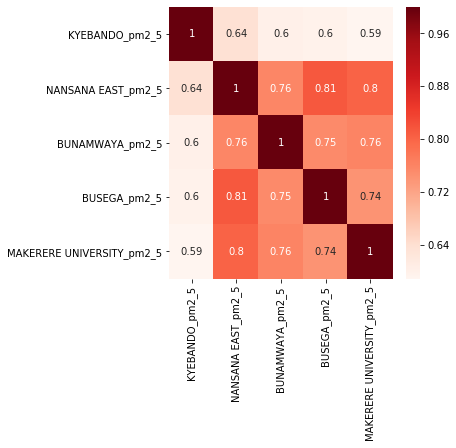

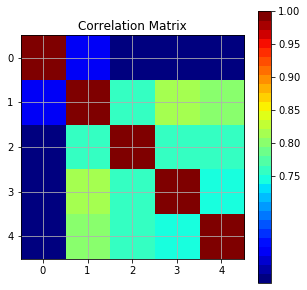

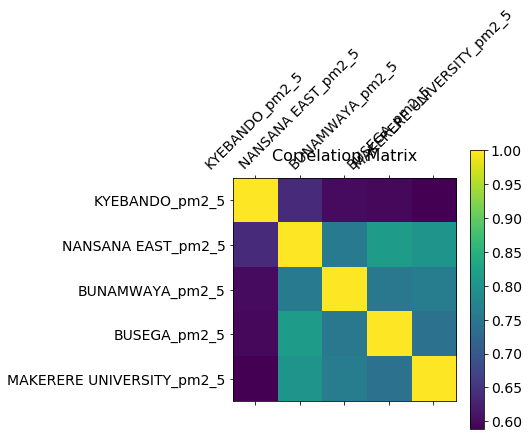

In [15]:
six_features = data[['kitch_outside_built_per_km', 'kitch_make_shift_per_km', 'cook_firewood_per_km', 
                      'cook_charc_per_km', 'waste_burn_per_km','pop_density']]

kmeans_clustering(six_features, data, 5)